In [1]:
%reload_ext autoreload
%autoreload 2

Library import section

In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import utilities.Model_utilities as my_model_util
import matplotlib.pyplot as plt

GPU Settings section

In [3]:
policy = mixed_precision.Policy('mixed_float16') 
mixed_precision.set_global_policy(policy)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
1 Physical GPUs, 1 Logical GPUs


Learning constants section

In [12]:
image_height = 544
image_width = 736
n_classes = 7
list_labels = ['Ground', 'Biker', 'Pedestrian', 'Skateboarder', 'Cart', 'Car', 'Bus']

# images_path = "/media/anaph/My Passport/dataset/images/"    #MUST BE CHANGE TO YOU PATH
# label_path = "/media/anaph/My Passport/dataset/labels/"     #MUST BE CHANGE TO YOU PATH
images_path = "tmp/test/"    #MUST BE CHANGE TO YOU PATH
label_path = "tmp/label/"     #MUST BE CHANGE TO YOU PATH
model_save_path = "models/"

batch_size = 1

Model declaration

In [13]:
model = my_model_util.unet_custom(n_classes, image_height, image_width, model_depth=3, dropout=0.1)
# model.summary()

Model training

In [14]:
img_train_it, img_val_it = my_model_util.fetch_delimiter(images_path, label_path)

gen = my_model_util.fetch_gen(img_train_it, images_path,
                            label_path, batch_size = batch_size,
                            n_classes = n_classes,
                            height = image_height, width = image_width)

val = my_model_util.fetch_gen(img_val_it, images_path,
                            label_path, batch_size = batch_size, 
                            n_classes = n_classes, 
                            height = image_height, width = image_width)

model.compile(optimizer='adam',
              loss='mse',
              metrics=[my_model_util.iou_coef])
              
model.fit(gen,steps_per_epoch=1000,epochs=5,
            validation_data=val,validation_steps=50)
            
model.save(model_save_path)

Epoch 1/5
1000/1000 [==============================] - 63s 62ms/step - loss: 0.0504 - iou_coef: 0.5020 - val_loss: 0.0014 - val_iou_coef: 0.8898
Epoch 2/5
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0012 - iou_coef: 0.9025 - val_loss: 0.0011 - val_iou_coef: 0.9415
Epoch 3/5
1000/1000 [==============================] - 61s 61ms/step - loss: 8.9325e-04 - iou_coef: 0.9449 - val_loss: 8.7739e-04 - val_iou_coef: 0.9585
Epoch 4/5
1000/1000 [==============================] - 60s 60ms/step - loss: 7.8747e-04 - iou_coef: 0.9618 - val_loss: 7.6548e-04 - val_iou_coef: 0.9721
Epoch 5/5
1000/1000 [==============================] - 63s 63ms/step - loss: 7.4813e-04 - iou_coef: 0.9708 - val_loss: 8.3350e-04 - val_iou_coef: 0.9763
INFO:tensorflow:Assets written to: models/assets


Bind random colors to labels

In [19]:
color = my_model_util.gen_color_for_labels(list_labels)

Checking our model

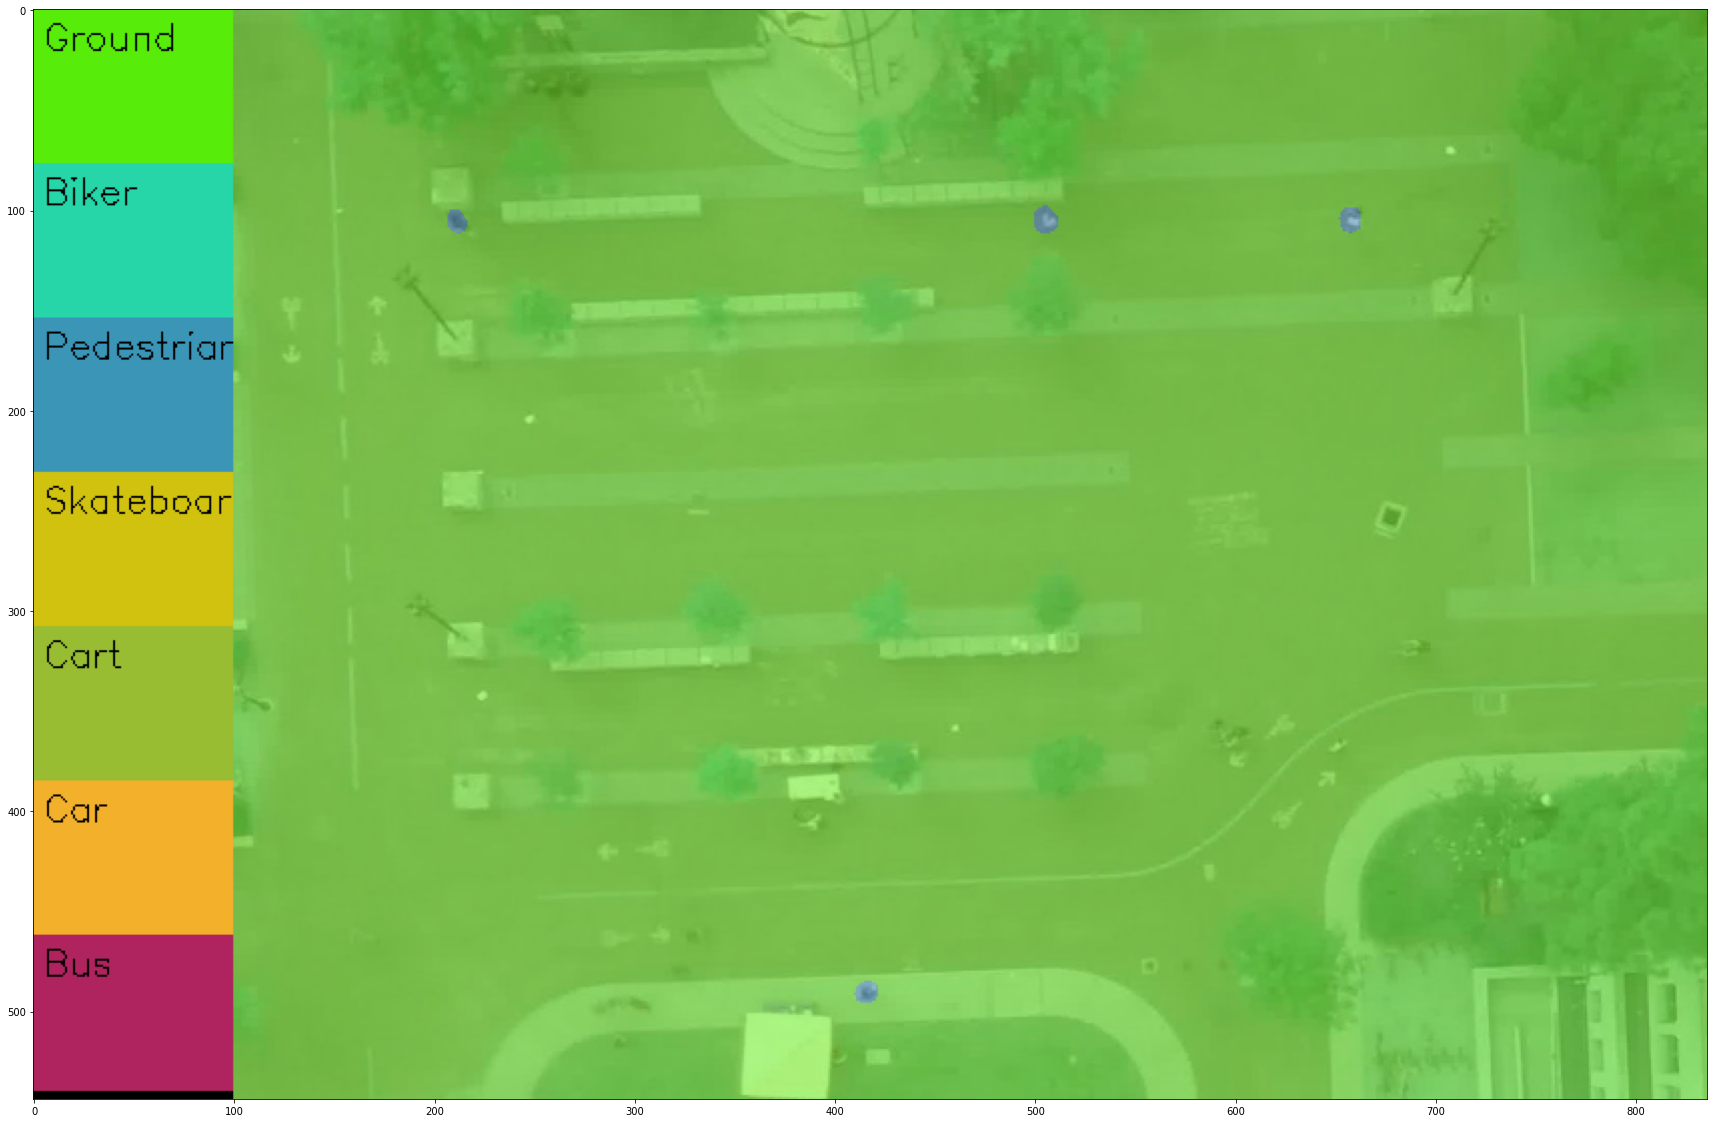

In [20]:
pr = my_model_util.predict_model_visualize(model, images_path + 'image7001.png',
                                            color, image_height, image_width)
plt.figure(figsize=(30, 30))
plt.imshow(pr)